## Import

In [1]:
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import skimage
import joblib
import pickle

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

### 1 - Décompressez les données dans un dossier, qui sera le chemin source. Dataset : https://vcla.stat.ucla.edu/people/zhangzhang-si/HiT/AnimalFace.zip

done

### 2 - Définissez une fonction pour lire, redimensionner et stocker les données dans un dictionnaire, contenant les images, les étiquettes (animal), les noms de fichiers originaux et une description. 

Les images elles-mêmes seront stockées sous forme de tableaux numpy contenant leurs valeurs RVB. Le dictionnaire sera enregistré dans un fichier pickle à l'aide de la librairie joblib. La structure des données sera basée sur celle utilisée pour les ensembles de données de test dans scikit-learn.

In [2]:
def resize_all(src, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary,
    together with labels and metadata. The dictionary is written to a pickle file
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
    
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []  
    
    # read all images in PATH, resize and write to data
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)

            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png', 'peg'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)

    return data


### 3. Créer le jeu de données en vous servant de votre fonction précédemment créée. Il y a pas mal d'animaux inclus dans le jeu de données, sélectionnez 8 classes d’animaux de votre choix. Nous définissons la largeur (et la hauteur) à 80 pixels.

In [3]:
#List of selected folders
listanimal = {'ChickenHead', 'BearHead', 'ElephantHead', 
           'EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead', 'SpiderHead'}

In [4]:
animaldata = resize_all(fr'Image', listanimal, 80, 80)

MonkeyHead
BearHead
ChickenHead
EagleHead
PandaHead
SpiderHead
ElephantHead
DeerHead


### 4. Analysez le nouveau jeu de données fraîchement créé (nombre d’échantillons, les éléments “clés” des données, taille des images, labels des images).


In [5]:
#Key element of data
print(animaldata.keys())

dict_keys(['description', 'label', 'filename', 'data'])


In [6]:
print(animaldata)

{'description': 'resized (80x80)animal images in rgb', 'label': ['Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monkey', 'Monk

In [7]:
#Number of elements
print(len(animaldata['data']))

800


In [8]:
#test on 3nd Image, we can see she have 80x80 pixel
print(animaldata['data'][3].shape)

(80, 80, 3)


In [9]:
#print unique label
print(np.unique(animaldata['label']))

['Bear' 'Chicken' 'Deer' 'Eagle' 'Elephant' 'Monkey' 'Panda' 'Spider']


### 5. Affichez un exemple de chaque animal inclus dans le jeu de données :

- Utilisez “np.unique” pour obtenir toutes les valeurs uniques dans la liste des étiquettes.

- Configurer la figure et les axes matplotlib, en fonction du nombre d'étiquettes.

- Faire un tracé pour chaque type d'étiquette. La méthode index renvoie l'index du premier élément correspondant à sa chaîne de recherche, label dans notre cas


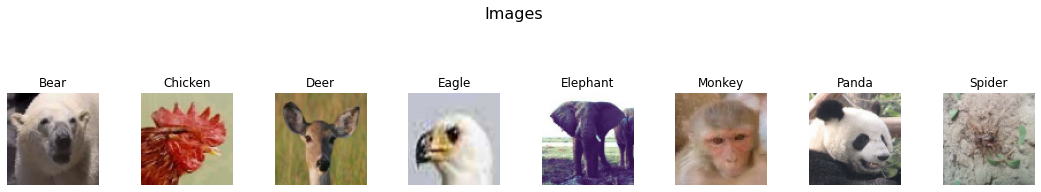

In [10]:
uniquelabel = np.unique(animaldata['label'])

# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, uniquelabel.shape[0])
fig.set_size_inches(15,4)
fig.tight_layout()
fig.suptitle('Images', fontsize=16)

for a, l in zip(axes, uniquelabel):
    
    idex = animaldata['label'].index(l)
    a.axis('off')
    
    a.imshow(animaldata['data'][idex])
    a.set_title(l)


In [11]:
X = np.array(animaldata['data'])
y = np.array(animaldata['label'])

### 6. Diviser vos données en un ensemble de test et un ensemble de train avec la fonction train_test_split de scikit-learn (80% de l'ensemble total pour l'entraînement et le reste pour l'ensemble de test). 

Dans l'ensemble de données, les photos sont classées par animal, nous ne pouvons donc pas simplement diviser à 80%, (si les données sont ordonnées et que nous nous divisons à une certaine position, nous nous retrouverons avec certains animaux (types) apparaissant dans un seul des deux ensembles).
Nous pouvons résoudre ce problème en mélangeant les données avant de les fractionner. De cette façon, nous égalisons les distributions dans l'ensemble de train et de test et les rendons comparables. La fonction “train_test_split” de sklearn fournit un paramètre shuffle pour prendre en charge cela tout en effectuant le fractionnement. “Random_state” amorce le mélange pour qu'il soit aléatoire, mais de manière reproductible.


In [12]:
X_trainT, X_testT, y_trainT, y_testT = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

### 7. Vérifier que la distribution des photos dans l'ensemble de formation et de test est similaire, (examiner le nombre relatif de photos par catégorie).

In [13]:
collections.Counter(y)

Counter({'Monkey': 100,
         'Bear': 100,
         'Chicken': 100,
         'Eagle': 100,
         'Panda': 100,
         'Spider': 100,
         'Elephant': 100,
         'Deer': 100})

In [14]:
collections.Counter(y_trainT)

Counter({'Chicken': 80,
         'Elephant': 78,
         'Eagle': 77,
         'Monkey': 76,
         'Bear': 87,
         'Panda': 87,
         'Deer': 77,
         'Spider': 78})

In [15]:
collections.Counter(y_testT)

Counter({'Elephant': 22,
         'Monkey': 24,
         'Spider': 22,
         'Eagle': 23,
         'Panda': 13,
         'Deer': 23,
         'Chicken': 20,
         'Bear': 13})

### Que pensez-vous des distributions ? Existe-t-il un moyen de s’assurer de l’obtention de distributions égales dans l'ensemble d'apprentissage et de test ?


La répartition est pas trop mal, cependant on prefere, avoir un equilibre et bien avoir 80/20 de chaque classe

pour cela on utilise le parametre : stratify 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

In [17]:
collections.Counter(y_train)

Counter({'Bear': 80,
         'Panda': 80,
         'Elephant': 80,
         'Eagle': 80,
         'Monkey': 80,
         'Spider': 80,
         'Deer': 80,
         'Chicken': 80})

In [18]:
collections.Counter(y_test)

Counter({'Monkey': 20,
         'Deer': 20,
         'Panda': 20,
         'Eagle': 20,
         'Bear': 20,
         'Chicken': 20,
         'Elephant': 20,
         'Spider': 20})

### 8. Traitement des données

Une approche classique de la reconnaissance d'objets est HOG-SVM, qui signifie Histogramme des dégradés orientés (Histogram of Oriented Gradients) et Support Vector Machines. Les HOG sont utilisés pour la réduction des caractéristiques, en d'autres termes : pour réduire la complexité du problème, tout en conservant autant de variations que possible.
Pour calculer un HOG, une image est divisée en blocs, par exemple 8 par 8 pixels. Pour chacun de ces blocs, la magnitude du gradient dans un nombre donné de directions est calculée. Pour une explication détaillée, vous pouvez vous référer à ce tutoriel : http://www.learnopencv.com/histogram-of-oriented-gradients/.


Le nombre de points de données à traiter dans notre modèle a été réduit à ~ 15%, et avec un peu d'imagination, nous pouvons encore reconnaître un chien dans le HOG.

Lors du calcul du HOG, nous effectuons une transformation. Nous pouvons transformer l'ensemble de notre ensemble de données à l'aide de transformateurs. Les transformateurs sont des objets qui se servent dans le tableau de données, transforment chaque élément et renvoient les données résultantes.

Ici, nous devons convertir les images couleur en niveaux de gris, calculer leurs HOG et enfin mettre à l'échelle les données. Pour cela, nous utilisons trois transformateurs à la suite: RGB2GrayTransformer, HOGTransformer et StandardScaler. Le résultat final est un tableau avec un HOG pour chaque image de l'entrée.

Scikit-learn est livré avec de nombreux transformateurs intégrés, tels qu'un StandardScaler pour mettre à l'échelle des entités et un Binarizer pour mapper des entités de chaîne à des entités numériques. De plus, il fournit les classes BaseEstimator et TransformerMixin pour faciliter la création de vos propres Transformers.
Un transformateur personnalisé peut être créé en héritant de ces deux classes (BaseEstimator, TransformerMixin) et en implémentant une méthode __init__, fit() et transform(). La classe TransformerMixin fournit la méthode fit_transform(), qui combine l'ajustement et la transformation que nous avons implémentés.

Créer vos classes  RGB2GrayTransformer and HOGTransformer
Après avoir instancié chaque transformateur (RGB2GrayTransformer(), HogTransformer(), StandardScaler()), mettez à l’échelle votre échantillon de données en appelant fit_transform() à chaque transformation en convertissant X_train étape par étape (RGB2GrayTransformer, puis HogTransformer, puis StandardScaler).


In [19]:

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """returns itself"""
        return self

    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
    

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """

    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)

        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [20]:
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()


X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)


In [21]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

### 9. Entraîner un classifieur. Nous commencerons par Stochastic Gradient Descent (SGD), car il est rapide et fonctionne relativement bien

In [22]:
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [23]:
y_pred = sgd.predict(X_test_prepared)

### 10. Évaluer les faux positifs grâce à une matrice de confusion.

In [24]:
confusion_matrix(y_test, y_pred)

array([[14,  0,  1,  0,  0,  5,  0,  0],
       [ 0, 16,  0,  0,  0,  2,  1,  1],
       [ 1,  0, 19,  0,  0,  0,  0,  0],
       [ 1,  1,  0, 13,  0,  3,  0,  2],
       [ 1,  0,  1,  0, 16,  1,  0,  1],
       [ 2,  0,  0,  0,  0, 15,  1,  2],
       [ 0,  0,  0,  0,  0,  1, 19,  0],
       [ 0,  2,  0,  3,  1,  1,  0, 13]])

### 11. Mettre en place un pipeline qui pré-traite les données (RGB2GrayTransformer(), HogTransformer(), StandardScaler()), entraîne le modèle et nous permet de modifier les paramètres plus facilement.

In [25]:
pipeline01 = Pipeline([
    ('gray', RGB2GrayTransformer()),
    ('hog', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scal', StandardScaler()),
    ('clas', SGDClassifier(random_state=42))
])

pipeline01.fit(X_train, y_train)

Pipeline(steps=[('gray', RGB2GrayTransformer()),
                ('hog',
                 HogTransformer(cells_per_block=(2, 2),
                                pixels_per_cell=(14, 14))),
                ('scal', StandardScaler()),
                ('clas', SGDClassifier(random_state=42))])

En utilisant un pipeline, nous pouvons optimiser à la fois les transformations et le classificateur en une seule procédure. De plus, au lieu de modifier manuellement les paramètres, nous pouvons utiliser un GridSearchCV. 

### 12./13./14. Pour cela, définir une grille de paramètres (param_grid = [{...}]).


In [26]:
param_grid = [
    {
        'hog__orientations': [8, 9],
        'hog__cells_per_block': [(2, 2), (3, 3)],
        'hog__pixels_per_cell': [(8, 8), (10, 10), (12, 12)],
        'clas': 
        [
            SGDClassifier(random_state=42),
            svm.SVC(kernel='linear'),
            GaussianNB(),
        ]
    }
]

In [27]:
g_search = GridSearchCV(pipeline01, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1,
                           return_train_score=True)

g_result = g_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.2min finished


In [28]:
g_result.best_estimator_

Pipeline(steps=[('gray', RGB2GrayTransformer()),
                ('hog', HogTransformer(cells_per_block=(2, 2), orientations=8)),
                ('scal', StandardScaler()), ('clas', SVC(kernel='linear'))])

In [29]:
g_result.best_score_

0.8953125

In [30]:
best_pred = g_result.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  86.875


### 15. Enregistrer vos résultats dans un fichier pickle (joblib) afin de pouvoir recharger les résultats lorsque vous en aurez besoin (par ex avec Heroku). 

In [31]:
with open('hog_sgd_model.pkl','wb') as f:
    pickle.dump(g_result,f)

### TEST

In [32]:
imtest2 = imread("elephant-test.jpg")
imtest2 = [resize(imtest2, (80, 80))]

In [33]:
pred2 = g_result.predict(imtest2)

In [34]:
print(pred2)

['Elephant']


### 16. Créer votre propre dataset avec des images provenant de Google Image. Appliquer votre pipeline sur ce nouveau jeu de données. Au besoin, relancer un Grid Search.

J'ai rajouté un dataset de Snake et j'ai relancer mon notebook

#### Test

In [35]:
imtest3 = imread("spider-test.jpeg")
imtest3 = [resize(imtest3, (80, 80))]

In [36]:
pred3 = g_result.predict(imtest3)

In [37]:
print(pred3)

['Spider']


## 17. Deep learning

Vous vous rendez compte rapidement que la tâche de classification en Machine Learning atteint rapidement des limites de performance. Ne serait-ce pas le moment idéal pour poursuivre ce travail avec les réseaux neuronaux et plus spécifiquement les réseaux convolutionnels. La première étape est de réaliser une veille sur les réseaux neuronaux convolutionnels.
https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5082166-quest-ce-quun-reseau-de-neurones-convolutif-ou-cnn
https://medium.datadriveninvestor.com/introduction-to-how-cnns-work-77e0e4cde99b

La première implémentation se fera à l’aide de l’api Keras (Tensorflow)
Nous pourrons nous aider de ce tutoriel proposé par Keras pour mettre en place notre classifieur :

https://keras.io/examples/vision/image_classification_from_scratch/

Pour pouvoir comparer réellement des performances de classifieurs (notamment ML vs DL, il est nécessaire de les paramétrer finement. 
https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/
https://medium.com/@am.benatmane/keras-hyperparameter-tuning-using-sklearn-pipelines-grid-search-with-cross-validation-ccfc74b0ce9f

Pytorch est une Framework de machine Learning qui offre de très bonnes performances. Vous pouvez l’installer de la façon suivante :
https://pytorch.org/get-started/locally/

Puis le tester en l’adaptant sur notres tâche de classification d’images :
https://www.pluralsight.com/guides/image-classification-with-pytorch
